# 8. Convolutional neural network
You tested above different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by creating a ConvNet from scratch and using the pixel values from the original images to train the model?

What accuracy can you achieve?
Can you get good results? - If not, why?

In [49]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from PIL import Image
import h5py
import matplotlib.pyplot as plt
import os

**Comments:** In this model, we are not using high levels features. We will use the picture without any transformations and build a convolutional neural network to classify pictures.

## Load the data and labels

In [50]:
# Loading 1 image
path = r"C:\Users\Saulais\OneDrive - OCP SA\Bureau\EPFL\ADSML_Cours_4\Course Project\train\van\van-0023.png"

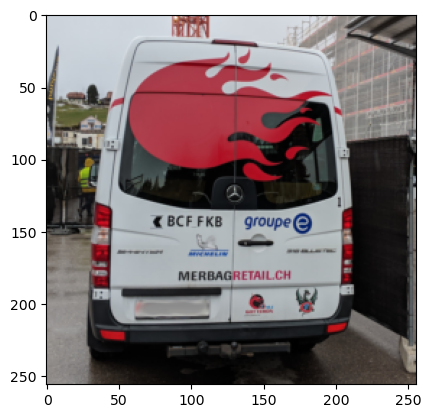

In [51]:
notebook_directory = os.getcwd()
train_path = os.path.join(notebook_directory, "train")
img = Image.open(path)
plt.imshow(img)
plt.show()

In [52]:
# Get image shape
image_width, image_height = img.size
print(f"Image shape (width, height): ({image_width}, {image_height})")


Image shape (width, height): (256, 256)


**Comments:** The image size is 256 x 256 x 3. we are using keras to load images and rescale them. There is no need for additional standardization.

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image generator with augmentation such as horizontal flip and rotation range to bring more diversity to the train set
train_generator = ImageDataGenerator(rescale= 1 / 255, horizontal_flip=True, rotation_range=5)

# Create the validation generator 
val_generator = ImageDataGenerator(rescale= 1/ 255)

# Create the test generator
test_generator = ImageDataGenerator(rescale= 1/ 255)

In [54]:
# Folder list
folder_list = ["bike", "car", "motorcycle", "other", "truck", "van"]

*Comments:* We do not shuffle data for the validation nor test set. In addition, we do not include subset as we have a separate set of data. We keep the default parameter. We keep the original picture size as target size. We set a batch size at 32 which looks a good compromise given the size of the data and to optimize computational spending

In [55]:
import os

# Train set 
trainset = train_generator.flow_from_directory(
    os.path.join("train"), 
    classes=folder_list,       
    batch_size=32, # We select 32 as a batch size
    class_mode="sparse",
    shuffle=True,
    target_size=(256, 256),
)

# validation and test sets
valset = val_generator.flow_from_directory(
    os.path.join("valid"), 
    classes=folder_list, 
    batch_size=32,
    class_mode="sparse",
    target_size=(256, 256),
    shuffle=False
)

testset = test_generator.flow_from_directory(
    os.path.join("test"),  
    classes=folder_list,     
    batch_size=32,
    target_size=(256, 256),
    shuffle=False
)


Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 52 images belonging to 6 classes.


In [56]:
# Access a single batch of images and labels from the trainset
data_tr, labels = next(trainset)

# Check the shape of images and labels
print(f"Image batch shape: {data_tr.shape}")  # (batch_size, height, width, channels)
print(f"Labels batch shape: {labels.shape}")  # (batch_size,)

Image batch shape: (32, 256, 256, 3)
Labels batch shape: (32,)


Images are in their original size of 256 x 256 x 3 in RGB format

In [57]:
import numpy as np

# Function to extract all images and labels from a generator
def extract_data_from_generator(generator):
    images = []
    labels = []
    
    for batch_images, batch_labels in generator:
        images.append(batch_images) 
        labels.append(batch_labels)  
        
        # Stop when all samples are processed
        if len(images) * generator.batch_size >= generator.n:
            break
    
    # Combine all batches into 1 array
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return images, labels

# Extract train, validation, and test data
X_tr, y_tr = extract_data_from_generator(trainset)
X_val, y_val = extract_data_from_generator(valset)
X_test, y_test = extract_data_from_generator(testset)

# Check shapes
print(f"Train Images Shape: {X_tr.shape}, Train Labels Shape: {y_tr.shape}")
print(f"Validation Images Shape: {X_val.shape}, Validation Labels Shape: {y_val.shape}")
print(f"Test Images Shape: {X_test.shape}, Test Labels Shape: {y_test.shape}")


Train Images Shape: (280, 256, 256, 3), Train Labels Shape: (280,)
Validation Images Shape: (139, 256, 256, 3), Validation Labels Shape: (139,)
Test Images Shape: (52, 256, 256, 3), Test Labels Shape: (52, 6)


**Comments:** y_test is one-hot-encoded. We transform the labels into numbers from 0 to 5

In [58]:
# Convert one-hot encoded test labels to numbers from 0 to 5
test_labels_converted = np.argmax(y_test, axis=1)

## Create the Model 
Once the sets are created, we implement the model


In [59]:
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import Sequential, layers, regularizers
import keras
from keras import layers


We create a model with 2 convolutional / max pooling layers and 2 dense layers. In addition, to prevent overfitting, we introduce dropout layers and L2 regularizers.
- We create one convolutional layer with 16 kernels, each kernel has a size of 5x5 and a stride of 2x2 with RELU activation 
- We add a max pooling layer with 16 channels, the pool size is 2x2 with the stride of 2
- We flatten the output before adding the final dense layers. 
- We add dropout layers to limit the overfitting

In [60]:
X_tr.shape

(280, 256, 256, 3)

In [61]:
# Create model
model = Sequential()
model.add(keras.Input(shape=(256, 256, 3)))  # 256x256 RGB images
model.add(layers.Conv2D(16, 5, strides=2, kernel_regularizer=regularizers.l2(0.01), activation="relu")) # We create one convolutional layer with 16 kernels,
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(16, 3, strides=1, kernel_regularizer=regularizers.l2(0.01), activation="relu")) # We create one convolutional layer with 16 kernels,
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
model.add(layers.Dropout(0.25))

# Flatten before Dense layers
model.add(layers.Flatten())
model.add(keras.layers.Dense(units=128, input_dim=961, kernel_regularizer=regularizers.l2(0.01), activation="relu"))
model.add(layers.Dropout(0.5))
model.add(keras.layers.Dense(units=6, activation="softmax"))

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15376)            

In [63]:
from tensorflow.keras import optimizers

# Define loss function, optimizer and metrics to track during training
model.compile(optimizer="sgd",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

In [64]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)

In [65]:
print(f"y_tr shape: {y_tr.shape}")
print(f"y_val shape: {y_val.shape}")


y_tr shape: (280,)
y_val shape: (139,)


## Fitting the model 

In [66]:
# Train model
history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=50, callbacks=[early_stopping])

Epoch 1/50
9/9 [==============================] - 2s 178ms/step - loss: 4.5781 - acc: 0.2429 - val_loss: 4.4672 - val_acc: 0.2374
Epoch 2/50
9/9 [==============================] - 1s 160ms/step - loss: 4.4672 - acc: 0.2643 - val_loss: 4.4542 - val_acc: 0.3094
Epoch 3/50
9/9 [==============================] - 1s 169ms/step - loss: 4.4389 - acc: 0.3071 - val_loss: 4.4352 - val_acc: 0.3165
Epoch 4/50
9/9 [==============================] - 1s 165ms/step - loss: 4.4127 - acc: 0.3036 - val_loss: 4.4139 - val_acc: 0.3022
Epoch 5/50
9/9 [==============================] - 2s 173ms/step - loss: 4.3326 - acc: 0.3536 - val_loss: 4.3811 - val_acc: 0.3094
Epoch 6/50
9/9 [==============================] - 2s 188ms/step - loss: 4.3375 - acc: 0.3286 - val_loss: 4.3721 - val_acc: 0.3669
Epoch 7/50
9/9 [==============================] - 2s 172ms/step - loss: 4.2983 - acc: 0.3821 - val_loss: 4.3597 - val_acc: 0.3094
Epoch 8/50
9/9 [==============================] - 2s 199ms/step - loss: 4.2687 - acc: 0.36

## Evaluate the model 

In [67]:
# The history object saved the scores during training
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

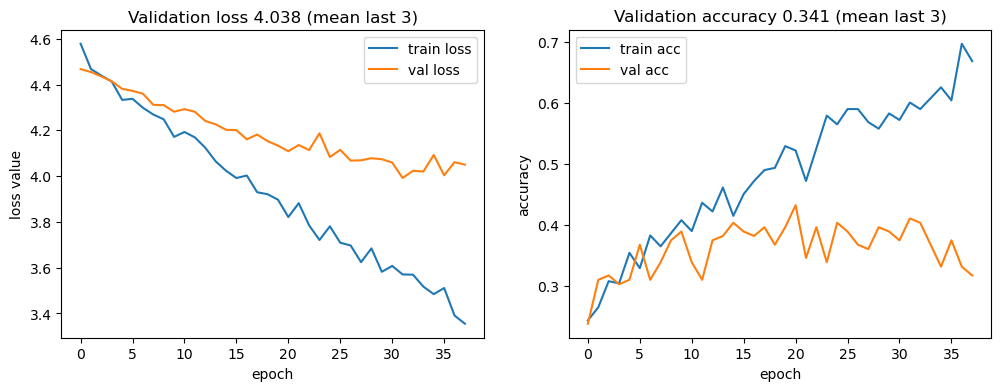

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.show()

**Comments:** the graphs shows overfitting as there is a growing difference between the validation and the train sets accuracy. The final accuracy is 0.381. Lets look at the prediction results in details.

In [69]:
(test_loss, test_accuracy) = model.evaluate(X_test, test_labels_converted , batch_size=32)
cnn_accuracy = test_accuracy * 100
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(cnn_accuracy))

2/2 [==============================] - 0s 26ms/step - loss: 4.0392 - acc: 0.3654
Test loss: 4.04
Test accuracy: 36.54%


In [70]:
# Save the score in the SQL Table 
import sqlite3

cnn_data = {'model': ['CNN'],
        'test_accuracy': [cnn_accuracy ]}
cnn_df = pd.DataFrame(cnn_data)

# Save to SQLite
conn = sqlite3.connect('results.db')
cnn_df.to_sql('results_table', conn, if_exists='append', index=False)
conn.close()

In [71]:
X_tr.shape, y_tr.shape

((280, 256, 256, 3), (280,))

In [73]:
test_preds_cnn = model.predict(X_test)
print("Predictions:", test_preds_cnn.shape)

Predictions: (52, 6)


test_preds_cnn = model.predict(X_test)
print("Predictions:", test_preds_cnn.shape)

In [74]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes,            # array with true labels
    y_pred=test_preds_cnn.argmax(axis=1),  # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = "Predictions"
matrix_df.index.name = "True class"
matrix_df

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,3,1,2,3,3,0
car,1,8,0,0,2,0
motorcycle,2,0,1,0,6,0
other,0,1,2,3,2,0
truck,1,0,1,2,3,0
van,1,1,0,0,2,1


*Comments:* We got an accuracy of 40% on the test set. The is accuracy is not good and may be due to the number of data and the lack of consistance in the images. Looking at the confusion matrix, we can see that major inacuracy were made. As an example, the model classified as car, 1 bike. Or classified as trucks 2 motorcycles and 1 bike . 
I believe we can work on both tuning the model and improving the training set. 

- **Improving the model** We should tune the L2 hyperparameters. 
- **Improving the data** The lighting and the position of vehicules should be standardized. By trainning the model on a wider range of vehicules and storing the coefficients, we could certainly improve the model. In addition, we could emphasize on picture with bikes or motorcycles to reduce mistakes done.


In [75]:
from tensorflow.keras import Sequential, layers

# Define a simple model
model = Sequential([
    layers.Dense(5, input_shape=(784,), activation="relu")  # 784 input features, 5 output neurons
])

# Get weights and biases of the Dense layer
weights_hidden, biases_hidden = model.layers[0].get_weights()

print(f"Weights shape: {weights_hidden.shape}")  # (784, 5)
print(f"Biases shape: {biases_hidden.shape}")    # (5,)


Weights shape: (784, 5)
Biases shape: (5,)


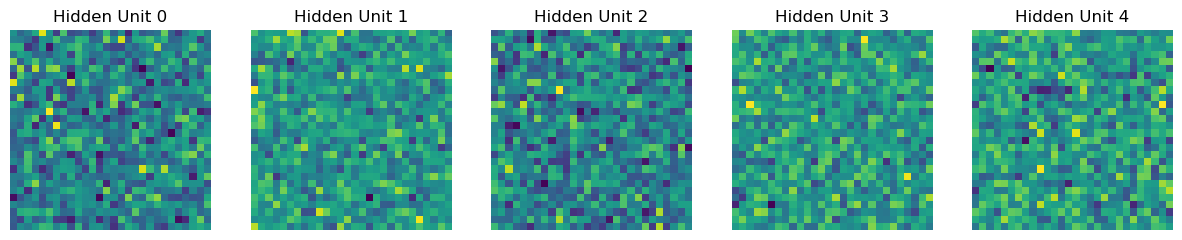

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Example weights_hidden with shape (784, 5)
weights_hidden = np.random.randn(784, 5)  # Simulate weights for visualization

# Visualize weights for each hidden unit
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 5 hidden units

for i, ax in enumerate(axes):
    weights = weights_hidden[:, i].reshape(28, 28)  # Reshape for a 28x28 grid
    ax.imshow(weights, cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Hidden Unit {i}")

plt.show()

# Built with the help of chatGPT - OpenAI